In [3]:
import os
os.environ['XLA_FLAGS'] = '--xla_cpu_enable_fast_math=false'                                     


import jax.numpy as jnp
import numpy as onp
from jax.scipy.stats import norm
from scipy.stats import norm as spnorm
from jax import jit
from jax import vmap
from jax import grad
from jax.config import config; config.update("jax_enable_x64", True)



from ml_tools.jax_kernels import ard_rbf_kernel_efficient

In [4]:
# Let's make a really simple example.
onp.random.seed(2)
x = onp.random.uniform(-2, 2, size=50).reshape(-1, 1)

In [5]:
lscale = onp.reshape(onp.random.uniform(1, 5), (1,))
alpha = 1.

k_true = ard_rbf_kernel_efficient(x, x, alpha, lscale, jitter=0)

/anaconda2/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
draw = onp.random.multivariate_normal(onp.zeros(x.shape[0]), k_true)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

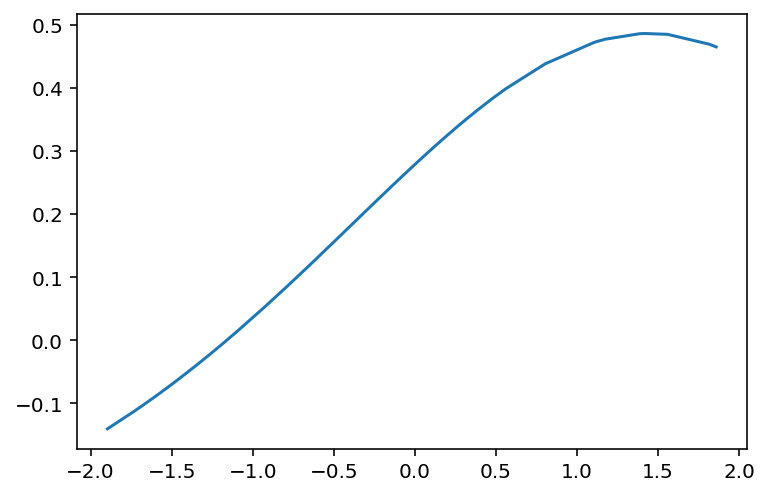

In [8]:
order = onp.argsort(x[:, 0])

plt.plot(x[order], draw[order])

In [9]:
# Draw some data
probs = spnorm.cdf(draw)

In [10]:
y = onp.random.binomial(1, probs)

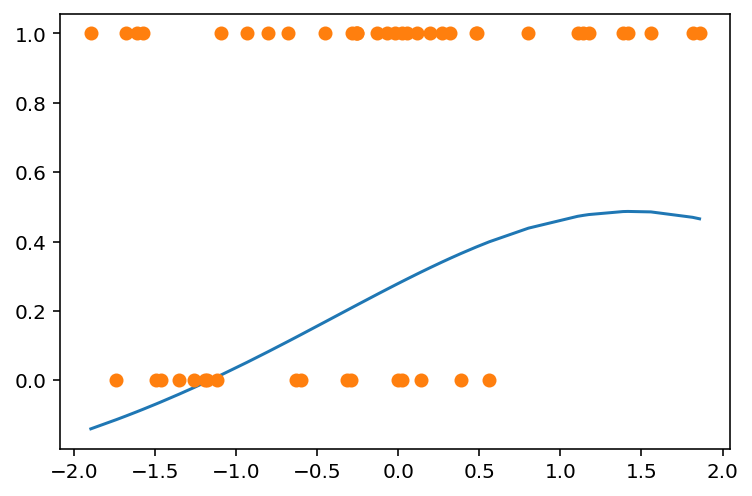

In [11]:
plt.plot(x[order], draw[order])
plt.plot(x[order], y[order], marker='o', linestyle='none')

In [12]:
# Great. I have my input data x, and my outcomes y.

In [13]:
# I'm going to start with 10 inducing points.

In [14]:
n_inducing = 10

m = onp.random.randn(n_inducing)
L = jnp.zeros((n_inducing, n_inducing))

In [15]:
indices = jnp.tril_indices(L.shape[0])
num_indices = indices[0].shape[0]

In [16]:
random_vals = onp.random.randn(num_indices)

In [17]:
from jax.ops.scatter import index_update

In [18]:
L = index_update(L, indices, random_vals)

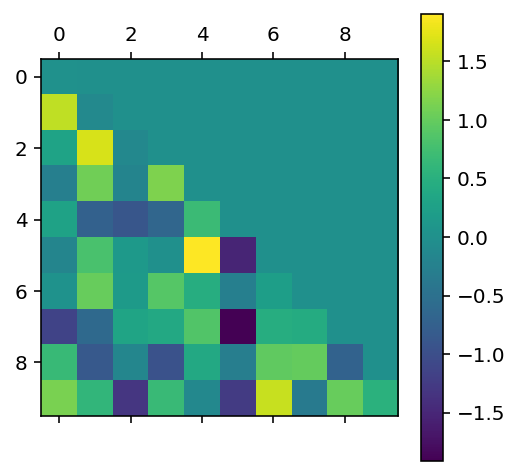

In [19]:
plt.matshow(L)
plt.colorbar()

In [20]:
Z = onp.random.uniform(-2, 2, 10).reshape(-1, 1)

In [21]:
from scipy.integrate import quad

In [22]:
def get_batch(x, y, batch_size=-1):
    
    if batch_size == -1:
        return x, y

    chosen = onp.random.choice(x.shape[0], size=batch_size, replace=False)
    
    x_batch = x[chosen]
    y_batch = y[chosen]
    
    return x_batch, y_batch

In [89]:
def project_to_f(kmm, knm, knn, m, L):
    
    mean = knm @ jnp.linalg.solve(kmm, m)

    S = L @ L.T 
    
    V1 = jnp.linalg.solve(kmm, S - kmm)
    V2 = jnp.linalg.solve(kmm, knm.T)
    
    cov = knn + knm @ V1 @ V2
    
    return mean, cov

def compute_qf_mean_cov(L, m, X, Z, cur_kern):
    
    knm = cur_kern(X, Z)
    kmm = cur_kern(Z, Z)
    knn = cur_kern(X, X)

    mean, cov = project_to_f(kmm, knm, knn, m, L)
    
    return mean, cov

In [90]:
@jit
def log_y_f(y, f):
    
    return y * norm.logcdf(f) + (1 - y) * norm.logcdf(-f)

In [91]:
from functools import partial
from kl import mvn_kl
from quadrature import expectation

mvn_kl_jit = jit(mvn_kl)

alpha = 1.2
lscale = jnp.array([2.])

def compute_expected_log_lik(mean, cov, y_batch):
    
    return jnp.sum(expectation(y_batch, jnp.diag(cov), mean))

def compute_kl_term(m, L, Z, cur_kern):

    # For the log lik, we need q(u) and p(u).
    p_u_mean = jnp.zeros_like(m)
    p_u_cov = cur_kern(Z, Z)
    q_u_cov = L @ L.T
    q_u_mean = m

    kl = mvn_kl(q_u_mean, q_u_cov, p_u_mean, p_u_cov)
        
    return kl

In [98]:

ard_rbf_kernel_jit = jit(ard_rbf_kernel_efficient)

def compute_objective(x_batch, y_batch, m, L, Z, alpha, lscale):
    
    cur_kern = partial(
        ard_rbf_kernel_efficient, alpha=alpha, rho=lscale,
        jitter=1e-6)

    mean, cov = compute_qf_mean_cov(L, m, x_batch, Z, cur_kern)
    
    mu = mean
    sigma = jnp.diag(cov)
    expected_log_lik = compute_expected_log_lik(mu, cov, y_batch)
        
    kl_term = compute_kl_term(m, L, Z, cur_kern)
    cur_objective = expected_log_lik - kl_term
            
    return cur_objective

In [99]:
def extract_params(theta):
    
    # Get the parameters
    m = theta[:n_inducing]
    
    L = jnp.zeros((n_inducing, n_inducing))
    indices = jnp.tril_indices(L.shape[0])
    num_indices = indices[0].shape[0]
    
    L_elts = theta[n_inducing:n_inducing+num_indices]
    L = index_update(L, indices, L_elts)
        
    alpha, lscale = theta[-2:]**2
    lscale = jnp.reshape(lscale, (-1,))
    
    return m, L, alpha, lscale

def to_optimise(theta):
    
    x_batch, y_batch = get_batch(x, y)
    
    m, L, alpha, lscale = extract_params(theta)
            
    cur_objective = -compute_objective(x_batch, y_batch, m, L, Z, alpha, lscale)
    
    print(m)
    print(cur_objective)
    
    return cur_objective

In [100]:
def to_optimise_with_grad(theta):
    
    cur_val = to_optimise(theta)
    
    cur_grad = grad(to_optimise)(theta)
        
    return cur_val, cur_grad

In [101]:
start_vals = jnp.concatenate([
    onp.random.randn(n_inducing),
    random_vals,
    jnp.reshape(alpha, (-1,)),
    jnp.reshape(lscale, (-1,))
])

In [102]:
from scipy.optimize import minimize

In [104]:
result = minimize(to_optimise_with_grad, start_vals, jac=True, tol=1e-1)

[-1.18692591 -0.68713695 -0.90188145  0.35176538 -0.71169277 -1.36932764
  1.05005083 -0.27511781  0.92081569  0.49727118]
11494787.712430706
Traced<ConcreteArray([-1.18692591 -0.68713695 -0.90188145  0.35176538 -0.71169277 -1.36932764
  1.05005083 -0.27511781  0.92081569  0.49727118])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(11494787.712430706)>with<JVPTrace(level=1/0)>
[-1.18692591 -0.68713695 -0.90188145  0.35176538 -0.71169277 -1.36932764
  1.05005083 -0.27511781  0.92081569  0.49727118]
11494787.712430706
Traced<ConcreteArray([-1.18692591 -0.68713695 -0.90188145  0.35176538 -0.71169277 -1.36932764
  1.05005083 -0.27511781  0.92081569  0.49727118])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(11494787.712430706)>with<JVPTrace(level=1/0)>
[-1.06181981 -0.66330325 -0.77602952  0.37461793 -0.6816915  -1.10651752
  0.83144711 -0.29304867  0.76802824  0.29614357]
6086917.475448955
Traced<ConcreteArray([-1.06181981 -0.66330325 -0.77602952  0.37461793 -0.6816915  -1.10651752
  0.8

[ 0.31015627  0.05209914 -0.60882636 -0.13013148 -0.2865713   0.29477684
  0.41680081 -0.09086187  0.94423489  0.77005022]
51.675405875201186
Traced<ConcreteArray([ 0.31015627  0.05209914 -0.60882636 -0.13013148 -0.2865713   0.29477684
  0.41680081 -0.09086187  0.94423489  0.77005022])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(51.675405875201186)>with<JVPTrace(level=1/0)>
[ 0.2821808   0.01582175 -0.65769397 -0.16968769 -0.26018156  0.17580344
  0.33188733 -0.06556741  0.87369147  0.73515179]
51.60255799420176
Traced<ConcreteArray([ 0.2821808   0.01582175 -0.65769397 -0.16968769 -0.26018156  0.17580344
  0.33188733 -0.06556741  0.87369147  0.73515179])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(51.60255799420176)>with<JVPTrace(level=1/0)>
[ 0.25151259 -0.02258713 -0.69504313 -0.19465974 -0.19793063  0.04746867
  0.29289173  0.00826926  0.83162269  0.7954046 ]
51.589079245270995
Traced<ConcreteArray([ 0.25151259 -0.02258713 -0.69504313 -0.19465974 -0.19793063  0.04746867
  0.29

[ 0.19344489 -0.03357298 -0.69707484 -0.16009286 -0.22835446  0.13679777
  0.31219752  0.00880177  0.83019978  0.77084487]
51.48788530697567
Traced<ConcreteArray([ 0.19344489 -0.03357298 -0.69707484 -0.16009286 -0.22835446  0.13679777
  0.31219752  0.00880177  0.83019978  0.77084487])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(51.48788530697567)>with<JVPTrace(level=1/0)>
[ 0.19396689 -0.03209678 -0.69549317 -0.1602199  -0.2291955   0.13864369
  0.31289833  0.00905882  0.83140963  0.77147486]
51.48785560447665
Traced<ConcreteArray([ 0.19396689 -0.03209678 -0.69549317 -0.1602199  -0.2291955   0.13864369
  0.31289833  0.00905882  0.83140963  0.77147486])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(51.48785560447665)>with<JVPTrace(level=1/0)>
[ 0.19448043 -0.03140411 -0.69496535 -0.16016448 -0.22923846  0.13896735
  0.31333683  0.00901167  0.8319291   0.77144653]
51.48783994167472
Traced<ConcreteArray([ 0.19448043 -0.03140411 -0.69496535 -0.16016448 -0.22923846  0.13896735
  0.31333

[ 1.24564445  0.24185955  0.04785375  0.22134051  0.02129005  0.63364119
  0.90518374 -0.05259522  1.68520497  1.34257007]
50.37210101089248
Traced<ConcreteArray([ 1.24564445  0.24185955  0.04785375  0.22134051  0.02129005  0.63364119
  0.90518374 -0.05259522  1.68520497  1.34257007])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(50.37210101089248)>with<JVPTrace(level=1/0)>
[1.60338155 0.32871943 0.34348862 0.57881193 0.18329946 0.80320056
 1.29336241 0.14336027 2.08910328 1.83168806]
52.658498083367874
Traced<ConcreteArray([1.60338155 0.32871943 0.34348862 0.57881193 0.18329946 0.80320056
 1.29336241 0.14336027 2.08910328 1.83168806])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(52.658498083367874)>with<JVPTrace(level=1/0)>
[1.34720771 0.26651948 0.13178589 0.32282833 0.06728529 0.6817799
 1.0153895  0.00303747 1.79987361 1.48143298]
50.13409860323659
Traced<ConcreteArray([1.34720771 0.26651948 0.13178589 0.32282833 0.06728529 0.6817799
 1.0153895  0.00303747 1.79987361 1.48143298]

[ 0.80618087  0.2412857   0.2109593   0.91562223 -0.10067296  1.33557965
  1.43924836 -0.14426445  1.88398156  0.81903281]
45.786905457596475
Traced<ConcreteArray([ 0.80618087  0.2412857   0.2109593   0.91562223 -0.10067296  1.33557965
  1.43924836 -0.14426445  1.88398156  0.81903281])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(45.786905457596475)>with<JVPTrace(level=1/0)>
[ 0.78558076  0.20018028  0.32416952  0.92953167 -0.14267499  1.39671618
  1.48847302 -0.1178294   1.91359318  0.80120573]
45.59554431486559
Traced<ConcreteArray([ 0.78558076  0.20018028  0.32416952  0.92953167 -0.14267499  1.39671618
  1.48847302 -0.1178294   1.91359318  0.80120573])>with<JVPTrace(level=1/0)>
Traced<ConcreteArray(45.59554431486559)>with<JVPTrace(level=1/0)>
[ 0.76018874  0.14588938  0.48547387  0.95562461 -0.2057497   1.50718179
  1.55678261 -0.0649661   1.93941586  0.76753309]
45.46912979609421
Traced<ConcreteArray([ 0.76018874  0.14588938  0.48547387  0.95562461 -0.2057497   1.50718179
  1.556

KeyboardInterrupt: 

In [41]:
m, L, alpha, lscale = extract_params(result.x)

In [42]:
lscale

array([0.66565097])

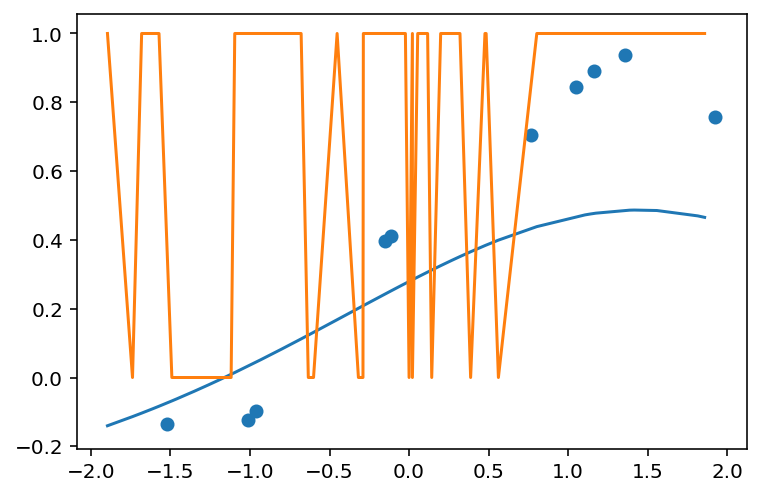

In [43]:
plt.scatter(Z[:, 0], m)
plt.plot(x[order], draw[order])
plt.plot(x[order], y[order])

In [44]:
m

array([ 0.41225604, -0.09765641,  0.70429302,  0.75611224, -0.12296176,
        0.89147205,  0.84571802, -0.13541635,  0.93759714,  0.3970187 ])

In [47]:
m_cov = L @ L.T

In [48]:
m_var = jnp.diag(m_cov)

In [50]:
from ml_tools.plotting import plot_with_error_bars_sd

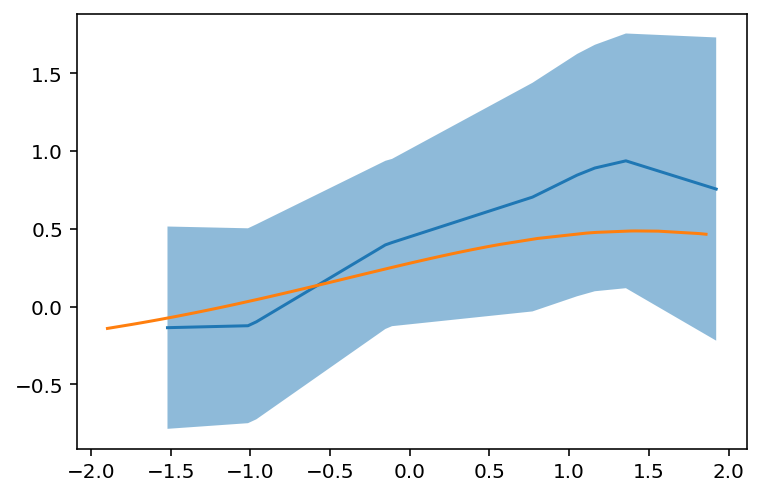

In [65]:
o_m = jnp.argsort(Z[:, 0])

plot_with_error_bars_sd(Z[o_m, 0], m[onp.array(o_m)], jnp.sqrt(m_var[o_m]))
plt.plot(x[order], draw[order])

In [53]:
o_m

DeviceArray([7, 4, 1, 9, 0, 2, 6, 5, 8, 3])

In [62]:
m[o_m]

/anaconda2/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


IndexError: too many indices for array